Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [29]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal, Constant
from glob import glob

In [11]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [30]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CXR_data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CXR_data/Test')

In [31]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2253
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [32]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=os.listdir(data_dir_train),
    batch_size=batch_size,
    validation_split=.2,
    subset='training',
    image_size=(img_height, img_width),
    seed=123
)

Found 18753 files belonging to 9 classes.
Using 15003 files for training.


In [34]:
## Writing validation dataset using image_dataset_from_directory.
# It's important that I used the param validation_split so that I can use only 20% of data for the validation set.

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    class_names=os.listdir(data_dir_train),
    batch_size=batch_size,
    validation_split=.2,
    subset='validation',
    image_size=(img_height, img_width),
    seed=123
)

Found 18753 files belonging to 9 classes.
Using 3750 files for validation.


In [35]:
# Listing out all the classes of skin cancer which correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['melanoma', 'seborrheic keratosis', 'vascular lesion', 'dermatofibroma', 'actinic keratosis', 'squamous cell carcinoma', 'pigmented benign keratosis', 'basal cell carcinoma', 'nevus']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

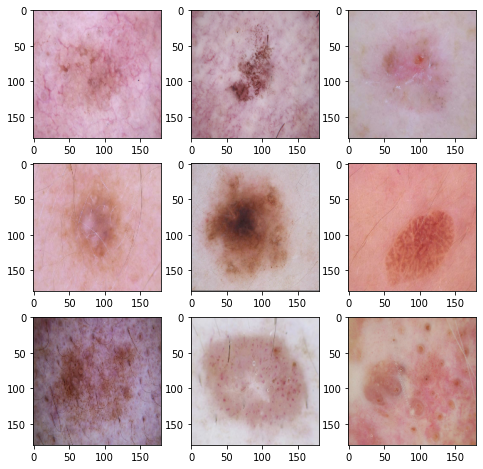

In [ ]:
import matplotlib.pyplot as plt

### Visualizing a single image from each of the 9 classes in our data
plt.figure(figsize=(8, 8))

def preview_data(num_of_images, dataset):
  for img, label in dataset.take(1):
    for i in range(9):
      axes = plt.subplot(3, 3, i + 1)
      plt.imshow(img[i].numpy().astype("uint8"))

preview_data(9, train_ds)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [36]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We will be using a mix of convolution, pooling, dense and flatten layers to build our covnet. We've kept it rather shallow to avoid a length model training time. This can be explored and iterated on in the future.


In [ ]:
# setting the number of classes as 9. We will use this variable at the end of each model in order to attain probability values for each class.
number_of_classes = 9

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(12, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(24, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(48, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(96, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
# We will be using Adam as an optimizer and categorical crossentry as the loss function.
# These are common to use in classification tasks.
# Our metric is accuracy here but it is important to note that ultimately our model should perform well across a variety of other metrics like precision and recall
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
# viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 12)      336       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 24)        2616      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 48)        1

### Train the model

In [ ]:
# Training the model using our training data and validating on the validation set we created earlier.
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 258s 2s/step - loss: 1.9108 - accuracy: 0.3072 - val_loss: 1.6923 - val_accuracy: 0.3653
Epoch 2/20
57/57 [==============================] - 48s 850ms/step - loss: 1.5744 - accuracy: 0.4469 - val_loss: 1.6041 - val_accuracy: 0.4031
Epoch 3/20
57/57 [==============================] - 48s 847ms/step - loss: 1.4592 - accuracy: 0.5031 - val_loss: 1.4190 - val_accuracy: 0.4944
Epoch 4/20
57/57 [==============================] - 48s 850ms/step - loss: 1.3728 - accuracy: 0.5270 - val_loss: 1.4382 - val_accuracy: 0.4989
Epoch 5/20
57/57 [==============================] - 48s 849ms/step - loss: 1.3318 - accuracy: 0.5409 - val_loss: 1.5134 - val_accuracy: 0.4766
Epoch 6/20
57/57 [==============================] - 48s 849ms/step - loss: 1.3219 - accuracy: 0.5459 - val_loss: 1.3223 - val_accuracy: 0.5256
Epoch 7/20
57/57 [==============================] - 48s 850ms/step - loss: 1.1785 - accuracy: 0.5882 - val_loss: 1.4014 - val_accuracy: 0.5122
E

### Visualizing training results

Let's now plot the accuracy and loss curves as it relates to our training and validation sets. Do we see that they follow the same path or does our validation set fall short due to over or underfitting?

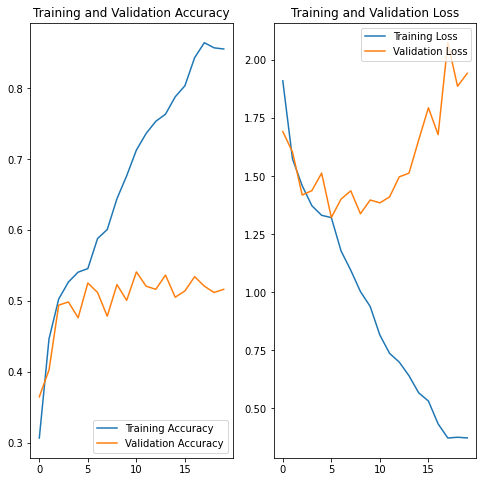

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

It appears that the model is overfitting to the data. The validation accuracy remains slow to increase over time while the training accuracy increases quite rapdily after several epochs. We'll use a variety of data augmentation steps to help the model learn from different views of the data. It's important to note that we can flip, rotate and zoom our imagery because of the modality it is. If we were looking at x-rays we would be limited in the augmentation we can perform.



In [37]:
# Our model is most definitely overfitting as our validation accuracy is poor while our training accuracy is higher.
# Let's move forward by augmented our data by flipping, rotating and zooming; common augmenting techniques for imagery.
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
    ])

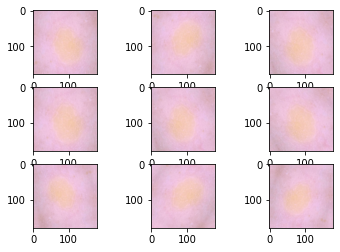

In [38]:
# Adding one image to preview augmented in 9 different ways
for img, label in train_ds.take(1):
    for i in range(9):
      augmented_images = data_augmentation(img)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_images[0].numpy().astype("uint8"))

### Todo:
### Create the model, compile and train the model


In [39]:
# Although the model has appeared to overfit, we will not be adding dropout layer at this time to avoid increased training time.
# We can re-evaluate after we see model performance. 

number_of_classes = 9

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(12, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(24, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(48, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(96, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax')
])


### Compiling the model

In [ ]:
# Using the same optimizer and loss metric for compliing our model.
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 63s 1s/step - loss: 2.2342 - accuracy: 0.1931 - val_loss: 2.1053 - val_accuracy: 0.2606
Epoch 2/20
57/57 [==============================] - 61s 1s/step - loss: 2.0275 - accuracy: 0.2081 - val_loss: 2.1119 - val_accuracy: 0.3430
Epoch 3/20
57/57 [==============================] - 60s 1s/step - loss: 1.8496 - accuracy: 0.3300 - val_loss: 1.8015 - val_accuracy: 0.3363
Epoch 4/20
57/57 [==============================] - 60s 1s/step - loss: 1.6748 - accuracy: 0.4101 - val_loss: 1.6901 - val_accuracy: 0.3987
Epoch 5/20
57/57 [==============================] - 60s 1s/step - loss: 1.5755 - accuracy: 0.4658 - val_loss: 1.6324 - val_accuracy: 0.4031
Epoch 6/20
57/57 [==============================] - 60s 1s/step - loss: 1.6122 - accuracy: 0.4391 - val_loss: 1.6368 - val_accuracy: 0.4187
Epoch 7/20
57/57 [==============================] - 60s 1s/step - loss: 1.5264 - accuracy: 0.4686 - val_loss: 1.5651 - val_accuracy: 0.4343
Epoch 8/20
57/57 [==

### Visualizing the results

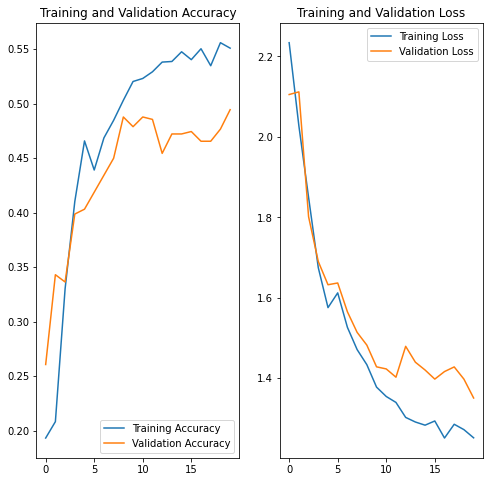

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Even though we added data augmentation, we still see that the training and validation sets are performing poorly. However, the validation and training set accuracy are much closer together now so it's less likely to do with imagery and potentially to do with class imbalance. The model is now underfit.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

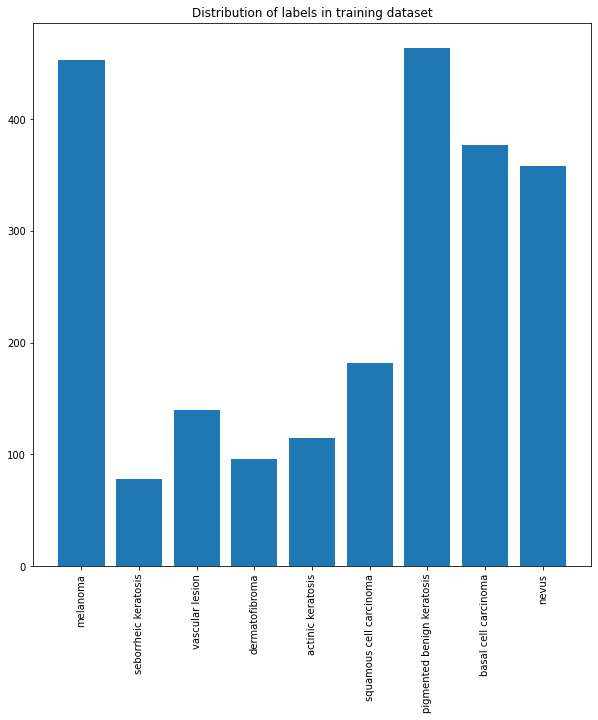

In [40]:
def get_dist(directory):
  data_dist = {}
  for name in class_names:
    path = os.path.join(directory, name)
    count = len(os.listdir(path))
    data_dist[name] = count
  return data_dist

train_data_dist = get_dist(data_dir_train)
    
plt.figure(figsize=(10, 10))
plt.bar(train_data_dist.keys(), train_data_dist.values())
plt.title('Distribution of labels in training dataset')
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
Our dataset is highly imbalanced. Fortunately there are a handful of libraries that can help us rebalance the dataset and augment the data in the process! Class imbalance can be a large problelm in boosting model performance. If any particular class is disporportionatly represented in the dataset, the model will tend to focus its learnings on that class feature, resulting in an underfit model.
#### - Which class has the least number of samples?
Seborreic keratosis has the least number of samples in our training set.
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis dominates the data in terms of number of samples.



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:
path_to_training_dataset= str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 452 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F40AF121BB0>: 100%|██████████| 500/500 [00:08<00:00, 59.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F40B32D0C40>: 100%|██████████| 500/500 [00:03<00:00, 148.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40AF712850>: 100%|██████████| 500/500 [00:02<00:00, 168.38 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F40B00E2040>: 100%|██████████| 500/500 [00:02<00:00, 192.18 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40B07EA3D0>: 100%|██████████| 500/500 [00:02<00:00, 192.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40AEEA1D60>: 100%|██████████| 500/500 [00:02<00:00, 197.16 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F40B0222580>: 100%|██████████| 500/500 [00:02<00:00, 170.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40B00D7DF0>: 100%|██████████| 500/500 [00:02<00:00, 180.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CXR_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F404EA07850>: 100%|██████████| 500/500 [00:07<00:00, 69.55 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

21000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
# creating paths for both original and augmented data
path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

# creating paths for both original and augmented data
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train,'*','*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
data_dict = dict(zip(path_list_new, lesion_list_new))

dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()), columns = ['Path','Label'])

dataframe_augmented_data = pd.DataFrame(list(data_dict.items()),columns = ['Path','Label'])
combined_dataframe = original_df.append(dataframe_augmented_data)

# checkign value counts to see how many images we have across classes
combined_dataframe['Label'].value_counts()

melanoma                      4753
seborrheic keratosis          2500
vascular lesion               2500
dermatofibroma                2500
squamous cell carcinoma       2500
pigmented benign keratosis    2500
basal cell carcinoma          2500
nevus                         2500
actinic keratosis             1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
data_dir_train="/content/gdrive/MyDrive/CXR_data/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23253 files belonging to 9 classes.
Using 18603 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 23253 files belonging to 9 classes.
Using 4650 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(60, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(120, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(240, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(240, activation='relu'),
    layers.Dense(number_of_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), loss="categorical_crossentropy", metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### **Todo:**  Train your model

In [ ]:
epochs = 20
## Using 20 epics as noted in the project requirements.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
582/582 [==============================] - 375s 645ms/step - loss: 1.4094 - accuracy: 0.4571 - val_loss: 1.2333 - val_accuracy: 0.5243
Epoch 2/20
582/582 [==============================] - 375s 644ms/step - loss: 1.2118 - accuracy: 0.5245 - val_loss: 1.0537 - val_accuracy: 0.5929
Epoch 3/20
582/582 [==============================] - 375s 644ms/step - loss: 1.0944 - accuracy: 0.5775 - val_loss: 1.0185 - val_accuracy: 0.6054
Epoch 4/20
582/582 [==============================] - 375s 644ms/step - loss: 0.9723 - accuracy: 0.6224 - val_loss: 0.8951 - val_accuracy: 0.6432
Epoch 5/20
582/582 [==============================] - 376s 645ms/step - loss: 0.8714 - accuracy: 0.6629 - val_loss: 0.8235 - val_accuracy: 0.6886
Epoch 6/20
582/582 [==============================] - 376s 646ms/step - loss: 0.7876 - accuracy: 0.6954 - val_loss: 0.7382 - val_accuracy: 0.7194
Epoch 7/20
582/582 [==============================] - 375s 644ms/step - loss: 0.7079 - accuracy: 0.7250 - val_loss: 0.6384 -

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Our augmentation to help class rebalance did get rid of overfitting and underfitting. It appears that the model is performing somewhat adaquetly. In addition, class rebalance helped the model avoid underfitting to the data.
- While normalization of the data is a standard process in preparing data for machine learning, it is worth noting that our use of normalizing the data betwen 0-1 vs 1-255 helped in model training.
- We used dropout after various layers to help with underfitting. This did help in model performance by helping the model learn better from the data.
- However, model architecture and learning rate is someting that I would play with next to better under optimize the model for the task. 